In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import random
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<Figure size 640x480 with 0 Axes>

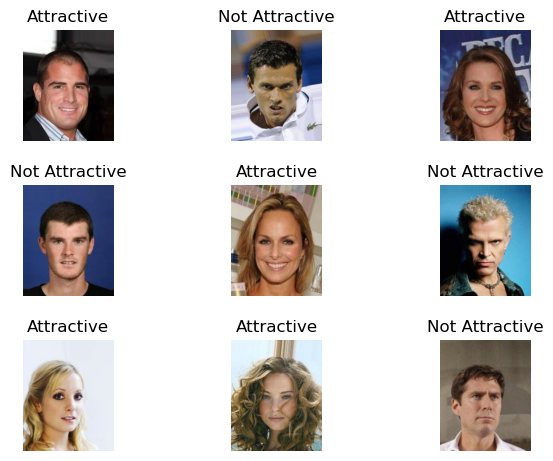

In [7]:
df = pd.read_csv('archive/list_attr_celeba.csv')
random.seed(1234)

im_path = "archive/img_align_celeba/img_align_celeba/"

plt.figure()

r, c = 3, 3

_, axarr = plt.subplots(r, c)
plt.tight_layout()

for i in range(r):
    for j in range(c):
        index = random.randint(0, df.shape[0])
        
        attr = 1 if df["Attractive"][index] == 1 else 0
        image = Image.open(im_path + df["image_id"][index])
        
        axarr[i][j].imshow(image)
        axarr[i][j].set_title("Attractive" if attr else "Not Attractive")
        axarr[i][j].axis("off")

     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   
5  000006.jpg                -1                1           1               -1   
6  000007.jpg                 1               -1           1                1   
7  000008.jpg                 1                1          -1                1   
8  000009.jpg                -1                1           1               -1   
9  000010.jpg                -1               -1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -

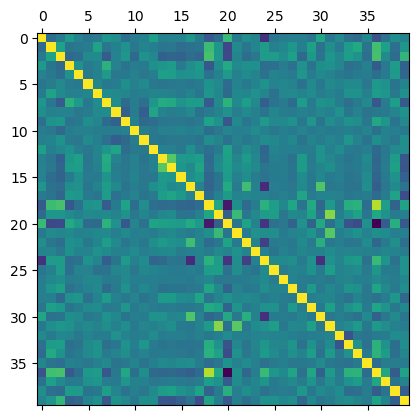

In [8]:
print(df[:10])
corr_matrix = df.drop(['image_id'], axis=1).corr()

plt.matshow(df.drop(['image_id'], axis=1).corr())
plt.show()

In [9]:
class FaceDataset(Dataset):
    def __init__(self, csv_file, root, train=True, transform=None):
        self.ann = pd.read_csv(csv_file)
        self.root = root
        self.train = train
        self.transform = transform
    
    def __len__(self):
        if self.train:
            return 7 * self.ann.shape[0] // 10
        else:
            return self.ann.shape[0] - 7 * self.ann.shape[0] // 10
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_name = os.path.join(self.root, self.ann.at[idx, "image_id"])
        image = Image.open(image_name)
        
        attractive = int((self.ann.at[idx, "Attractive"] + 1) / 2) # Turn -1 to 0
        
        if self.transform:
            image = self.transform(image).to(torch.float32)
        
        return image, attractive

(-0.5, 177.5, 217.5, -0.5)

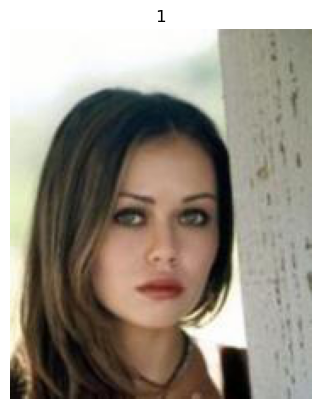

In [10]:
data = FaceDataset('archive/list_attr_celeba.csv',
                   'archive/img_align_celeba/img_align_celeba/',
                    None,
                  )

idx = 102
plt.imshow(data[idx][0])
plt.title(data[idx][1])
plt.axis("off")

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'mps'

In [12]:
# Basic model no convolutional layers
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        out = self.linear(x)
        return out

In [13]:
class ConvolutionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), padding=1, stride=(2, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), padding=1, stride=(2, 2)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), padding=1, stride=(2, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Flatten(),
            nn.Linear(33, 2)
        )
        
    def forward(self, x):
        return self.conv(x)

In [14]:
model_L = BasicModel().to(device)
model_C = ConvolutionalModel().to(device)
print(model_L)
print(model_C)

BasicModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
ConvolutionalModel(
  (conv): Sequential(
    (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=33, out_features=2, bias=True)
  )

In [15]:
basic_transforms = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(),
    v2.Resize((28, 28))
])

conv_transforms = v2.Compose([
    v2.ToImage(),
])

X = basic_transforms(data[0][0].resize((28, 28))).to(torch.float32)
out = model_L(X.to(device)).to(device)
nn.Softmax(dim = 1)(out)

tensor([[1.0000e+00, 1.8952e-09]], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [16]:
# Data Prep
train_dataloader = DataLoader(
    FaceDataset(
        'archive/list_attr_celeba.csv',
        'archive/img_align_celeba/img_align_celeba/',
        train=False,
        transform=conv_transforms
    ),
    batch_size=64
)

test_dataloader = DataLoader(
    FaceDataset(
        'archive/list_attr_celeba.csv',
        'archive/img_align_celeba/img_align_celeba/',
        train=False,
        transform=conv_transforms
    ),
    batch_size=64
)

# idx = 102
# plt.imshow(train_dataloader.dataset[idx][0])
# plt.title(train_dataloader.dataset[idx][1])
# plt.axis("off")

In [17]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

In [18]:
def train_loop(data_loader, loss_fn, optimizer, model):
    size = len(data_loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        y_hat = model(X.to(device))
        loss = loss_fn(y_hat.to(device), y.to(torch.long).to(device))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(data_loader, loss_fn, model):
    model.eval()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in data_loader:
            y_hat = model(X.to(device))
            test_loss += loss_fn(y_hat.to(device), y.to(device)).item()
            correct += (y_hat.argmax(1) == y.to(device)).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
train_dataloader.dataset[0][0].shape

torch.Size([3, 218, 178])

In [20]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, loss_fn, optimizer, model_C)
    test_loop(test_dataloader, loss_fn, model_C)
print("Done!")

Epoch 1
-------------------------------
loss: 0.686784  [   64/60780]
loss: 0.691997  [ 6464/60780]
loss: 0.692922  [12864/60780]
loss: 0.643525  [19264/60780]
loss: 0.620688  [25664/60780]
loss: 0.609864  [32064/60780]
loss: 0.509420  [38464/60780]
loss: 0.579433  [44864/60780]
loss: 0.674735  [51264/60780]
loss: 0.626962  [57664/60780]
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.607253 

Epoch 2
-------------------------------
loss: 0.644258  [   64/60780]
loss: 0.633783  [ 6464/60780]
loss: 0.572537  [12864/60780]
loss: 0.632495  [19264/60780]
loss: 0.550947  [25664/60780]
loss: 0.606678  [32064/60780]
loss: 0.543264  [38464/60780]
loss: 0.566946  [44864/60780]
loss: 0.630549  [51264/60780]
loss: 0.594596  [57664/60780]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.581695 

Epoch 3
-------------------------------
loss: 0.573953  [   64/60780]
loss: 0.639288  [ 6464/60780]
loss: 0.532424  [12864/60780]
loss: 0.639720  [19264/60780]
loss: 0.550466  [25664/60780]
loss: 0.579026  [32064/607

In [66]:
varr_image = Image.open("varr.jpeg")
emma_image = Image.open("emma.jpeg")
jenn_image = Image.open("test.jpeg")
henr_image = Image.open("henr.jpeg")
varr2_image = Image.open("varr2.jpeg")
varr3_image = Image.open("varr3.jpeg")
varrnana_image = Image.open("varrnana.jpeg")
alex_image = Image.open("alex.jpeg")
images = [varr_image, emma_image, jenn_image, henr_image, varr2_image, varr3_image, varrnana_image, alex_image]
image_names = ["varr", "emma", "jenn", "henr", "varr", "varr", "varrnana", "ale"]

out = ["Not Attractive", "Attractive"]
rankings = []
with torch.no_grad():
    for i, img in enumerate(images):
        pred = model_C(conv_transforms(img).to(torch.float32).to(device))
        rankings.append((pred, i))
        
        print(pred)
        print(out[torch.argmax(nn.Softmax(dim=1)(pred))])

rankings.sort(key = lambda x: -x[0][0][1] + x[0][0][0])
print(rankings)
print("\n".join([image_names[a[1]] for a in rankings]))

tensor([[ 0.3423, -1.5289]], device='mps:0')
Not Attractive
tensor([[ 0.6318, -1.3257]], device='mps:0')
Not Attractive
tensor([[-0.2576, -0.2540]], device='mps:0')
Attractive
tensor([[ 2.1328, -1.7102]], device='mps:0')
Not Attractive
tensor([[ 0.8621, -0.7076]], device='mps:0')
Not Attractive
tensor([[ 0.1348, -0.4620]], device='mps:0')
Not Attractive
tensor([[ 0.6681, -0.9639]], device='mps:0')
Not Attractive
tensor([[ 2.1428, -0.9554]], device='mps:0')
Not Attractive
[(tensor([[-0.2576, -0.2540]], device='mps:0'), 2), (tensor([[ 0.1348, -0.4620]], device='mps:0'), 5), (tensor([[ 0.8621, -0.7076]], device='mps:0'), 4), (tensor([[ 0.6681, -0.9639]], device='mps:0'), 6), (tensor([[ 0.3423, -1.5289]], device='mps:0'), 0), (tensor([[ 0.6318, -1.3257]], device='mps:0'), 1), (tensor([[ 2.1428, -0.9554]], device='mps:0'), 7), (tensor([[ 2.1328, -1.7102]], device='mps:0'), 3)]
jenn
varr
varr
varrnana
varr
emma
ale
henr
